In [1]:
import numpy as np
import pandas as pd

from src.data_preprocessing import clean_text, transform_tfidf
from src.model import gradient_descent, predict, pred_to_accuracy, get_best_vals
from src.viz import graph_log_loss

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1129)>


In [2]:
# Read data
train_raw = pd.read_csv("data/train.csv")
test_raw = pd.read_csv("data/test.csv")
y_test_raw = pd.read_csv("data/submit.csv")

In [3]:
# Implement data cleaning and text preprocessing
test_raw = test_raw.join(y_test_raw["label"])
train_clean = clean_text(train_raw)
test_clean = clean_text(test_raw)
y_train = train_clean["label"].to_numpy()
y_test = test_clean["label"].to_numpy()

/Users/nuriaadellraventos/Library/CloudStorage/OneDrive-TheUniversityofChicago/Classes/MathML/proj/mathml_finalproj/src/data_preprocessing.py:28: FutureWarning: The default value of regex will change from True to False in a future version.
  col = col.str.replace('[^\w\s]', '')\


In [4]:
# tf-idf transformation
X_train, X_test, words = transform_tfidf(train_clean["text"], test_clean["text"])

X_train = X_train.todense()
X_test = X_test.todense()
X_train.shape

(18285, 16770)

In [5]:
n, p = X_train.shape

# Shuffle training data
indices = np.random.permutation(n)
X_train = X_train[indices,:]
y_train = y_train[indices]

# Set training parameters
folds = 3
n_alphas = 10
lambdas = [0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001, 0.000000001]

In [6]:
# Get average train log loss for each lambda and alpha
avg_loss_by_penalty = np.empty((n_alphas + 1,len(lambdas)))
for i, lambda_ in enumerate(lambdas):
    log_loss = np.empty((n_alphas+ 1,folds))
    buckets = list(range(0, n + 1, n//folds))
    
    for k in range(folds):
        val1 = buckets[k]
        val2 = buckets[k+1]

        X_val_bucket = X_train[val1:val2,:]
        X_train_buckets = np.delete(X_train, np.s_[val1:val2], axis=0)

        y_val = y_train[val1:val2]
        y_train2 = np.delete(y_train, np.s_[val1:val2], axis=0)

        log_loss[:,k] = gradient_descent(X_train_buckets, X_val_bucket, y_train2, y_val, n_alphas, lambda_, 0.01, 10000)

    avg_loss_by_penalty[:,i] = np.mean(log_loss, axis=1)

In [7]:
print(avg_loss_by_penalty)

[[0.33592591 0.07801244 0.06261679 0.06051059 0.06001571 0.06189016
  0.05875863 0.05745031]
 [0.40979702 0.07871303 0.06122939 0.05900706 0.0586835  0.05991481
  0.05815741 0.05901183]
 [0.46996714 0.07973245 0.06054208 0.06081402 0.05915846 0.06182727
  0.05827377 0.05846056]
 [0.53542442 0.08617223 0.05927442 0.05804054 0.05982761 0.0590107
  0.05712437 0.05858129]
 [0.59618949 0.08638103 0.06287458 0.05991889 0.06038193 0.05901097
  0.05952483 0.05990377]
 [0.64956832 0.08874911 0.06246779 0.05882319 0.06005938 0.0594711
  0.06145707 0.05908026]
 [0.68846696 0.09284336 0.06107447 0.05837756 0.06004626 0.06127201
  0.05826514 0.05672778]
 [0.72089833 0.0898428  0.06515932 0.05685907 0.05992253 0.05880447
  0.063315   0.05785526]
 [0.73383507 0.09357195 0.06272826 0.06063785 0.05942388 0.05820423
  0.0594343  0.05726231]
 [0.74025874 0.09624887 0.06321612 0.05958743 0.05966729 0.06014816
  0.06105913 0.05770469]
 [0.74441812 0.09933215 0.06518974 0.0578319  0.06044146 0.0577303
  0.0

<AxesSubplot:title={'center':'Average Log Loss by Model Specification'}, xlabel='lambda', ylabel='Average Log Loss'>

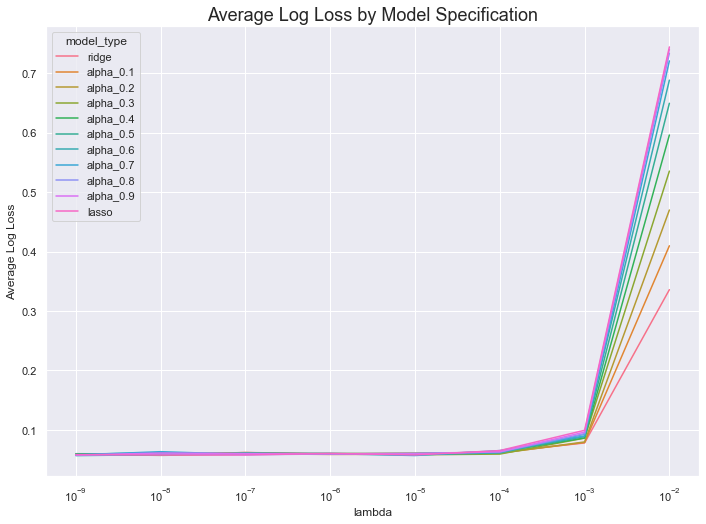

In [15]:
graph_log_loss(avg_loss_by_penalty, lambdas)

In [16]:
ridge_lambda, lasso_lambda, en_lambda, best_alpha = get_best_vals(avg_loss_by_penalty, lambdas)
print("Best lambda for ridge regularization: ", ridge_lambda)
print("Best lambda for lasso regularization: ", lasso_lambda)
print("Best lambda for elastic net regularization: ", en_lambda)
print("Best alpha for elastic net regularization: ", best_alpha)

Best lambda for ridge regularization:  1e-09
Best lambda for lasso regularization:  1e-08
Best lambda for elastic net regularization:  1e-09
Best alpha for elastic net regularization:  0.6000000000000001


In [34]:
# Train data predictions
train_pred_ridge = predict(X_train, y_train,  X_train, 0, ridge_lambda, 0.01, 100000)
train_pred_lasso = predict(X_train, y_train,  X_train, 1, lasso_lambda, 0.01, 100000)
train_pred_en = predict(X_train, y_train,  X_train, best_alpha, en_lambda, 0.01, 100000)

In [35]:
# Select threshold and calculate train accuracy
threshold = 0.5
train_accuracy_r = pred_to_accuracy(train_pred_ridge, y_train, threshold)
train_accuracy_l = pred_to_accuracy(train_pred_lasso, y_train, threshold)
train_accuracy_en = pred_to_accuracy(train_pred_en, y_train, threshold)
print(train_accuracy_r)
print(train_accuracy_l)
print(train_accuracy_en)

0.8244462674323216
0.8272901285206453
0.8172272354388843


In [39]:
# Test data predictions
pred_ridge = predict(X_train, y_train,  X_test, 0, ridge_lambda, 0.01, 100000)
pred_lasso = predict(X_train, y_train,  X_test, 1, lasso_lambda, 0.01, 100000)
pred_en = predict(X_train, y_train,  X_test, best_alpha, en_lambda, 0.01, 100000)

In [40]:
# Calculate test accuracy
accuracy_r = pred_to_accuracy(pred_ridge, y_test, threshold)
accuracy_l = pred_to_accuracy(pred_lasso, y_test, threshold)
accuracy_en = pred_to_accuracy(pred_en, y_test, threshold)
print(accuracy_r)
print(accuracy_l)
print(accuracy_en)

0.5630601092896175
0.56
0.5580327868852459
